In [1]:
!pip install loguru

<p>Implementing a decorator called 'train_time' that can be applied to a function to measure the execution time of the decorated function. The decorator is used to measure the training time of a machine learning model.</p>

<p>Measuring the training time of machine learning models is essential in the field of data to optimize resources, compare models and configurations, plan resources, optimize performance, and ensure the transparency and reproducibility of results. This helps improve the efficiency and quality of data modeling processes.</p>

In [2]:
def train_time(f):
    def wrapper(*args, **kwargs):
        start = datetime.now()
        print()
        clf, best_params = f(model=kwargs["model"], param_grid=kwargs["param_grid"], x_train=kwargs["x_train"], y_train=kwargs["y_train"])
        return datetime.now() - start, clf, best_params

    return wrapper

@train_time
def train_model(model, param_grid, x_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(x_train, y_train)
    best_params = grid_search.best_params_
    return grid_search.best_estimator_, best_params


def calculate_accuracy(model, y_test, x_test):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# HeartDisease Dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from scipy import stats
from sklearn.decomposition import PCA

from datetime import datetime
from loguru import logger
import json

import warnings
warnings.filterwarnings('ignore')

- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

In [4]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


- Numerical Features : Age, RestingBP, Cholesterol, MaxHR, Oldpeak
- Categorical Features : Sex, ChestPainType, FastingBS, RestingECG, ExerciseAngina, ST_Slope, HeartDisease

Histogram plot is a graph used to visualize the distribution of a dataset. It shows the frequency or the number of occurrences of different values within a continuous set of data. The histogram is employed to identify patterns, trends, and insights in the data, making it useful in areas such as statistics, data analysis, and engineering. It assists in identifying the shape of the distribution, detecting outliers, data segmentation, trend analysis, performance evaluation, and making informed decisions.

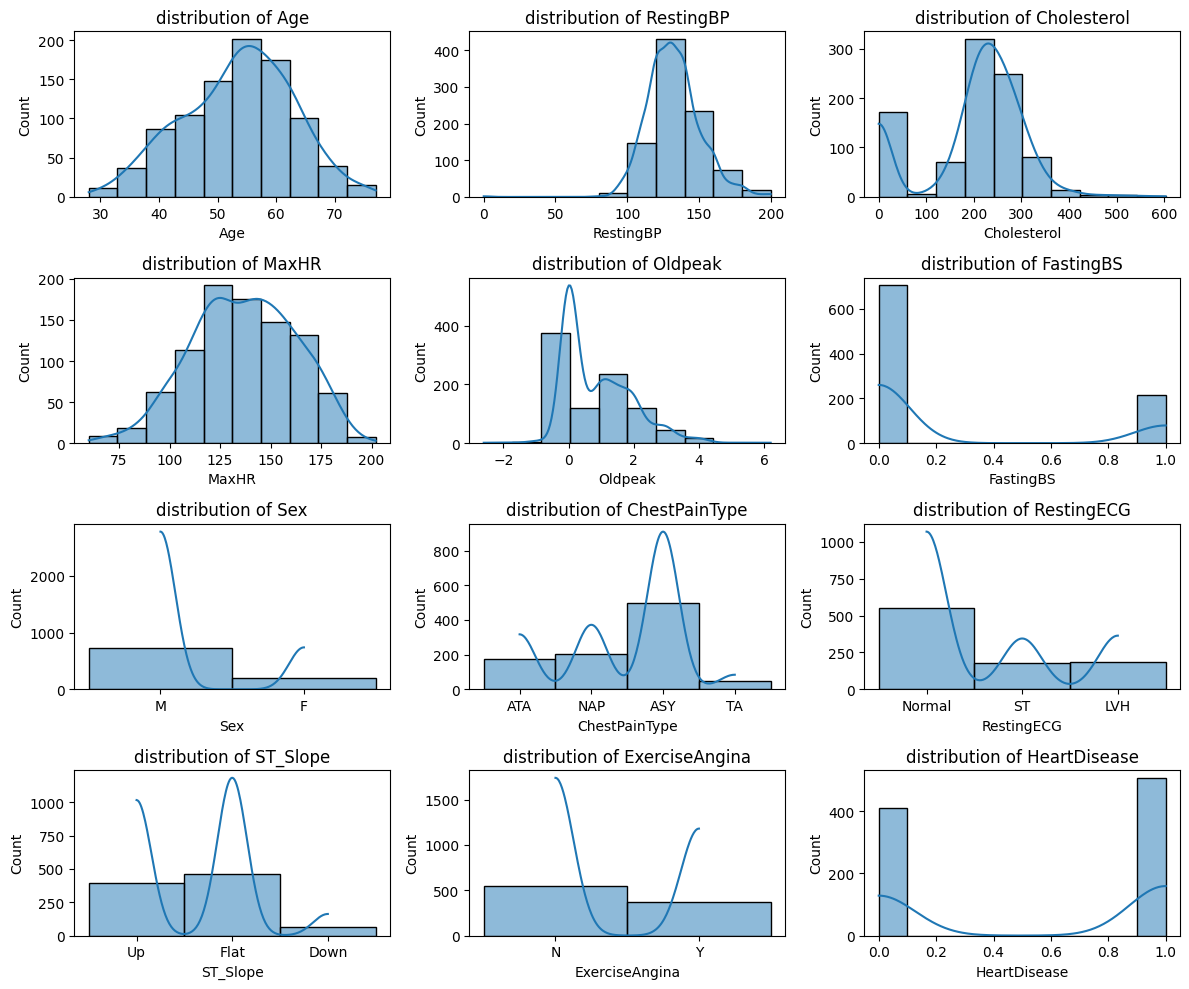

In [7]:
fig, axes = plt.subplots(4, 3, figsize=(12, 10))
columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak','FastingBS', 'Sex', 'ChestPainType', 'RestingECG', 'ST_Slope', 'ExerciseAngina', 'HeartDisease']
titles = ['distribution of ' + col for col in columns]

for i, col in enumerate(columns):
    sns.histplot(x=df[col], bins=10, kde=True, ax=axes[i // 3, i % 3]).set(title=titles[i])

plt.tight_layout()
plt.show()

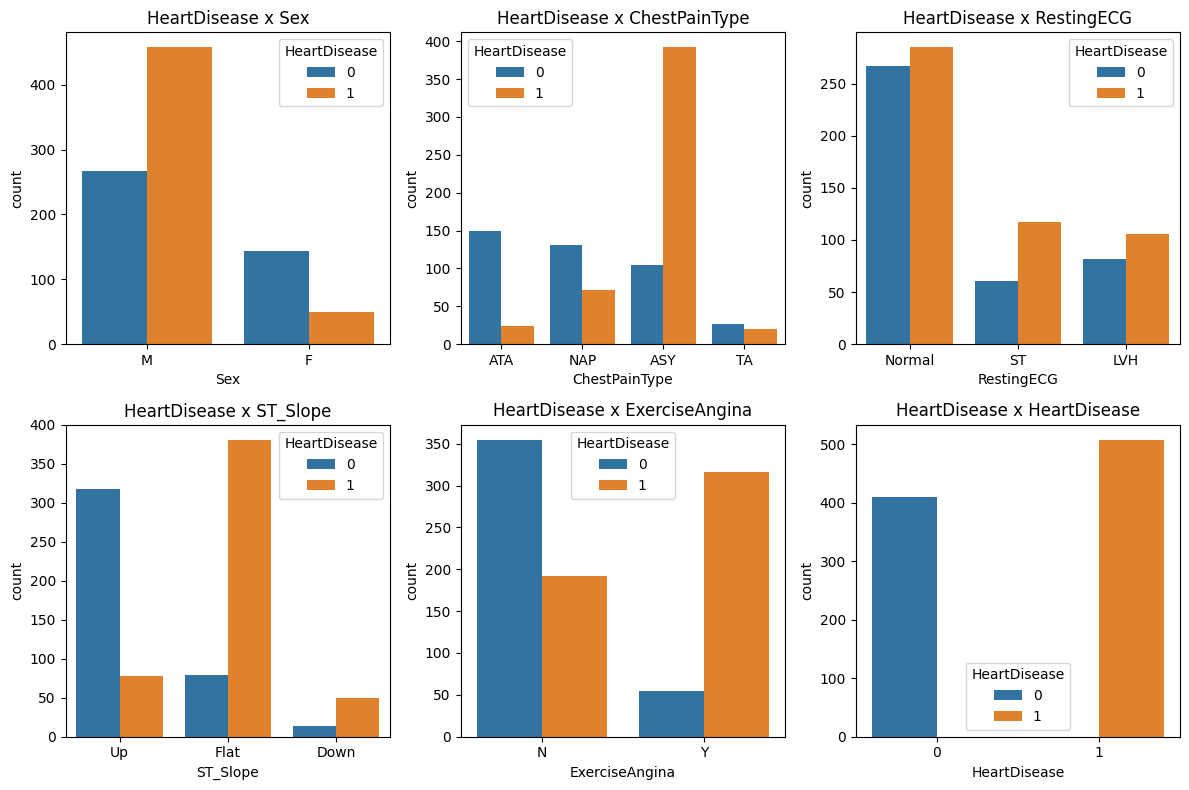

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
columns = ['Sex', 'ChestPainType', 'RestingECG', 'ST_Slope', 'ExerciseAngina', 'HeartDisease']
titles = ['HeartDisease x ' + col for col in columns]

for i, col in enumerate(columns):
    sns.countplot(data=df, x=col, hue='HeartDisease', ax=axes[i // 3, i % 3]).set_title(titles[i])

plt.tight_layout()
plt.show()

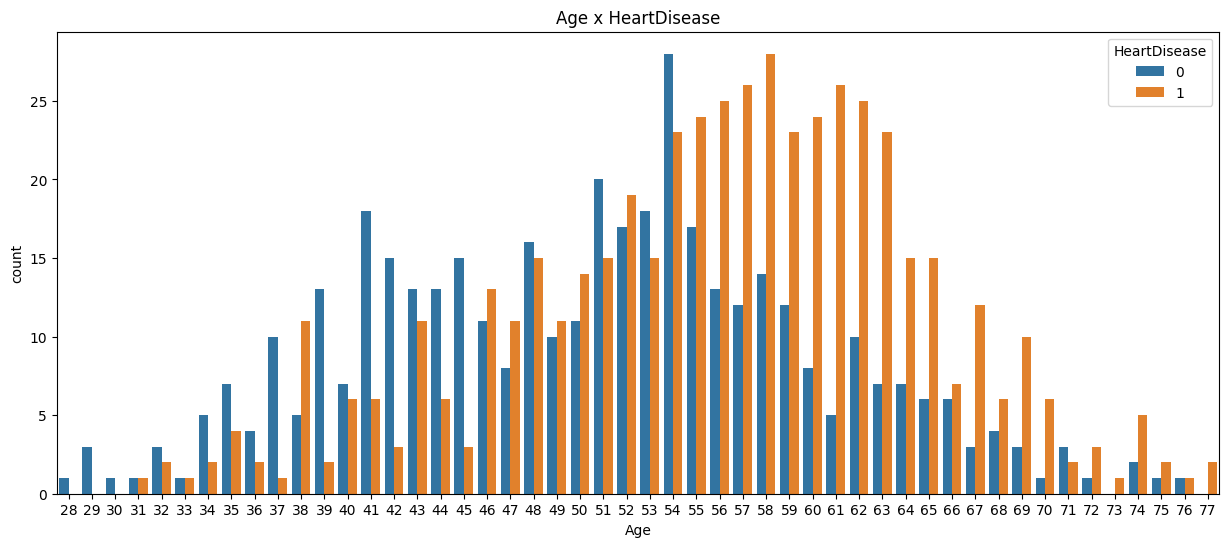

In [9]:
plt.figure(figsize=(15, 6))
plt.title('Age x HeartDisease')
sns.countplot(data=df, x='Age', hue='HeartDisease')
plt.show()

<p> We can observe that as a person ages, the risk of developing heart disease generally increases.<p>

In [10]:
# Converting strings into categorical numerical values
le = LabelEncoder()
feature = ['Sex', 'ChestPainType', 'RestingECG', 'ST_Slope', 'ExerciseAngina']
for col in feature:
    df[col] = le.fit_transform(df[col])

A correlation matrix is a table that shows the relationship between different variables in a dataset. It helps to identify whether the variables move together, in opposite directions, or have no relationship with each other. The values in the matrix range from -1 to 1, where 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and 0 indicates no correlation. It is a useful tool for understanding patterns and trends in the data.

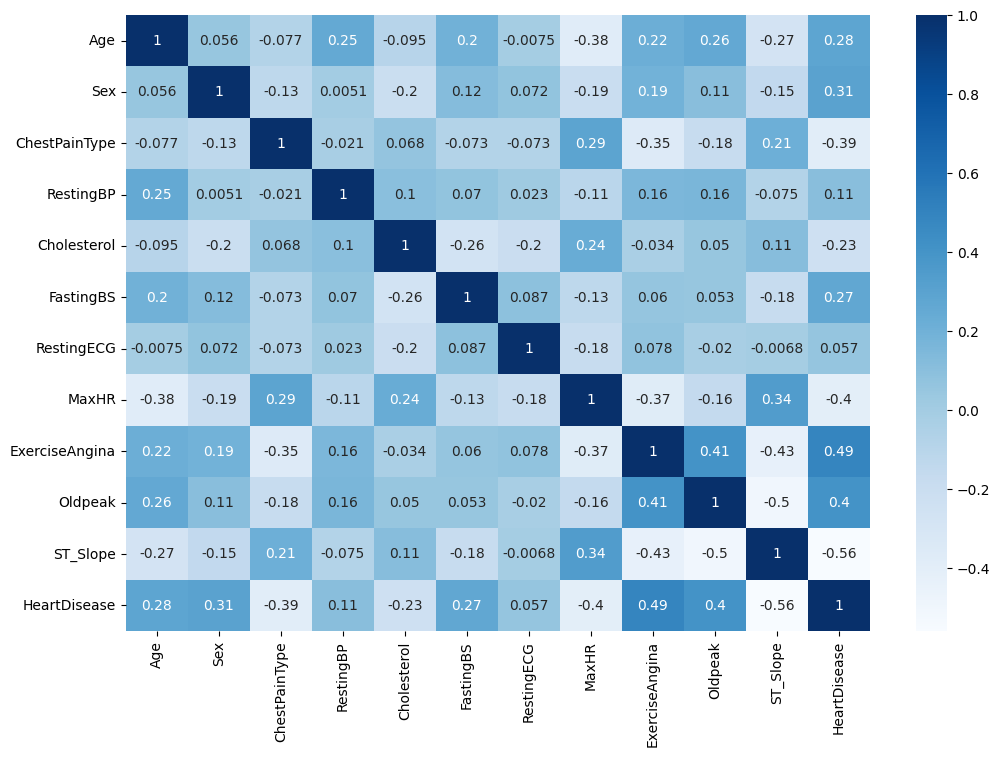

In [11]:
# Correlation Matrix
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.show()

In [12]:
ss = StandardScaler()
df['Oldpeak'] = ss.fit_transform(df[['Oldpeak']])
df['RestingBP'] = ss.fit_transform(df[['RestingBP']])
df['Age'] = ss.fit_transform(df[['Age']])
df['Cholesterol'] = ss.fit_transform(df[['Cholesterol']])
df['MaxHR'] = ss.fit_transform(df[['MaxHR']])
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,1,1,0.410909,0.825070,0,1,1.382928,0,-0.832432,2,0
1,-0.478484,0,2,1.491752,-0.171961,0,1,0.754157,0,0.105664,1,1
2,-1.751359,1,1,-0.129513,0.770188,0,2,-1.525138,0,-0.832432,2,0
3,-0.584556,0,0,0.302825,0.139040,0,1,-1.132156,1,0.574711,1,1
4,0.051881,1,2,0.951331,-0.034755,0,1,-0.581981,0,-0.832432,2,0


# Machine Learning

In [13]:
# Separating between features and target
x = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease']

In [14]:
# Separating the model between training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## GridSearchCV
<p>GridSearchCV is a technique for finding the best combination of hyperparameters for a machine learning model. It tests all possible combinations of hyperparameters, evaluating each one using cross-validation. The model with the best average performance is selected as the final result. GridSearchCV helps optimize the model's performance, but it can be computationally intensive.<p>
<p>This code automates the training and evaluation of multiple classification models using different parameters for each model. Through the loop and the models_list, the results are stored for each model, allowing for the comparison of model performances and the selection of the one that achieved the best performance for the specific classification task at hand. This facilitates the process of experimenting with various models and hyperparameters, making the development of a machine learning model more efficient and scalable.<p>

In [15]:
models_list = list()

models = [
    {'name': 'SVM', 'model': SVC(), 'param_grid': {'C': [0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3],
                                                   'gamma': [0.7, 0.8, 0.9, 1, 1.1, 1.2],
                                                   'kernel': ['linear', 'rbf']}},

    {'name': 'Random Forest', 'model': RandomForestClassifier(), 'param_grid': {'n_estimators': [10, 50, 100, 500, 1000],
                                                                                'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                                                                                'criterion': ['gini', 'entropy', 'log_loss']}},

    {'name': 'K-Nearest Neighbors', 'model': KNeighborsClassifier(), 'param_grid': {'n_neighbors': [3, 5, 7],
                                                                                    'p': [1, 2],'weights': ['uniform', 'distance'],
                                                                                    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                                                                                    'leaf_size': [10, 20, 30],
                                                                                    'metric': ['euclidean', 'manhattan', 'chebyshev'],
                                                                                    'n_jobs': [-1]}},

    {'name': 'Decision Tree', 'model': DecisionTreeClassifier(), 'param_grid': {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                                                                                'min_samples_split': [2, 5, 10]}},

    {'name': 'AdaBoost', 'model': AdaBoostClassifier(), 'param_grid': {'n_estimators': [50, 100, 200, 500],
                                                                       'learning_rate': [0.1, 0.5, 1.0],
                                                                       'algorithm': ['SAMME', 'SAMME.R']}},

    {'name': 'Gradient Boosting', 'model': GradientBoostingClassifier(), 'param_grid': {'n_estimators': [50, 100, 200, 500],
                                                                                         'learning_rate': [0.1, 0.5, 1.0],
                                                                                         'max_depth': [3, 4, 5],
                                                                                         'subsample': [0.8, 1.0]}},

    {'name': 'Logistic Regression', 'model': LogisticRegression(), 'param_grid': {'C': [0.1, 0.5, 1.0, 1.5, 2.0],
                                                                                   'solver': ['liblinear', 'saga'],
                                                                                   'penalty': ['l1', 'l2', 'elasticnet'],
                                                                                   'l1_ratio': [0.1, 0.5, 0.9]}},

    {'name': 'XGBoost', 'model': XGBClassifier(), 'param_grid': {'max_depth': [3, 4, 5, 6, 7],
                                                                 'learning_rate': [0.1, 0.01, 0.001],
                                                                 'n_estimators': [50, 100, 200, 500],
                                                                 'subsample': [0.8, 1.0],
                                                                 'colsample_bytree': [0.6, 0.8, 1.0]}},

    {'name': 'Naive Bayes', 'model': GaussianNB(), 'param_grid': {}}
]

for model_info in models:
    model_name = model_info.get("name")
    model = model_info.get("model")
    param_grid = model_info.get("param_grid")

    logger.info(f"Training Model {model_name}")

    time_to_train, clf, best_params = train_model(model=model, param_grid=param_grid, x_train=x_train, y_train=y_train)
    predicted_labels = clf.predict(x_test)
    accuracy = accuracy_score(y_test, predicted_labels)
    logger.info(f"Time to train model {time_to_train}")
    logger.info(f"Model accuracy {model_name}: {accuracy}")
    logger.info(f"Best Model Params {json.dumps(best_params, indent=4)}")

    result_model_info = {
        "model_name": model_name,
        "model_instance": clf,
        "model_accuracy": accuracy,
        "train_time": time_to_train,
    }

    models_list.append(result_model_info)

2023-07-15 02:00:40.816 | INFO     | __main__:<cell line: 45>:50 - Training Model SVM


2023-07-15 02:01:01.860 | INFO     | __main__:<cell line: 45>:55 - Time to train model 0:00:21.027772
2023-07-15 02:01:01.869 | INFO     | __main__:<cell line: 45>:56 - Model accuracy SVM: 0.855072463768116
2023-07-15 02:01:01.877 | INFO     | __main__:<cell line: 45>:57 - Best Model Params {
    "C": 0.7,
    "gamma": 0.7,
    "kernel": "linear"
}
2023-07-15 02:01:01.879 | INFO     | __main__:<cell line: 45>:50 - Training Model Random Forest


2023-07-15 02:07:29.351 | INFO     | __main__:<cell line: 45>:55 - Time to train model 0:06:27.456915
2023-07-15 02:07:29.353 | INFO     | __main__:<cell line: 45>:56 - Model accuracy Random Forest: 0.8913043478260869
2023-07-15 02:07:29.355 | INFO     | __main__:<cell line: 45>:57 - Best Model Params {
    "criterion": "entropy",
    "max_depth": 7,
    "n_estimators": 100
}
2023-07-15 02:07:29.359 | INFO     | __main__:<cell line: 45>:50 - Training Model K-Nearest Neighbors


2023-07-15 02:07:55.646 | INFO     | __main__:<cell line: 45>:55 - Time to train model 0:00:26.258295
2023-07-15 02:07:55.648 | INFO     | __main__:<cell line: 45>:56 - Model accuracy K-Nearest Neighbors: 0.8731884057971014
2023-07-15 02:07:55.653 | INFO     | __main__:<cell line: 45>:57 - Best Model Params {
    "algorithm": "auto",
    "leaf_size": 10,
    "metric": "manhattan",
    "n_jobs": -1,
    "n_neighbors": 7,
    "p": 1,
    "weights": "uniform"
}
2023-07-15 02:07:55.655 | INFO     | __main__:<cell line: 45>:50 - Training Model Decision Tree


2023-07-15 02:07:56.353 | INFO     | __main__:<cell line: 45>:55 - Time to train model 0:00:00.690911
2023-07-15 02:07:56.355 | INFO     | __main__:<cell line: 45>:56 - Model accuracy Decision Tree: 0.8333333333333334
2023-07-15 02:07:56.357 | INFO     | __main__:<cell line: 45>:57 - Best Model Params {
    "max_depth": 3,
    "min_samples_split": 2
}
2023-07-15 02:07:56.361 | INFO     | __main__:<cell line: 45>:50 - Training Model AdaBoost


2023-07-15 02:08:41.148 | INFO     | __main__:<cell line: 45>:55 - Time to train model 0:00:44.748346
2023-07-15 02:08:41.151 | INFO     | __main__:<cell line: 45>:56 - Model accuracy AdaBoost: 0.8768115942028986
2023-07-15 02:08:41.154 | INFO     | __main__:<cell line: 45>:57 - Best Model Params {
    "algorithm": "SAMME",
    "learning_rate": 1.0,
    "n_estimators": 200
}
2023-07-15 02:08:41.157 | INFO     | __main__:<cell line: 45>:50 - Training Model Gradient Boosting


2023-07-15 02:10:37.346 | INFO     | __main__:<cell line: 45>:55 - Time to train model 0:01:56.182812
2023-07-15 02:10:37.347 | INFO     | __main__:<cell line: 45>:56 - Model accuracy Gradient Boosting: 0.8623188405797102
2023-07-15 02:10:37.350 | INFO     | __main__:<cell line: 45>:57 - Best Model Params {
    "learning_rate": 0.1,
    "max_depth": 3,
    "n_estimators": 50,
    "subsample": 1.0
}
2023-07-15 02:10:37.353 | INFO     | __main__:<cell line: 45>:50 - Training Model Logistic Regression


2023-07-15 02:10:40.939 | INFO     | __main__:<cell line: 45>:55 - Time to train model 0:00:03.579234
2023-07-15 02:10:40.941 | INFO     | __main__:<cell line: 45>:56 - Model accuracy Logistic Regression: 0.8586956521739131
2023-07-15 02:10:40.945 | INFO     | __main__:<cell line: 45>:57 - Best Model Params {
    "C": 0.1,
    "l1_ratio": 0.1,
    "penalty": "l2",
    "solver": "liblinear"
}
2023-07-15 02:10:40.947 | INFO     | __main__:<cell line: 45>:50 - Training Model XGBoost


2023-07-15 02:15:29.597 | INFO     | __main__:<cell line: 45>:55 - Time to train model 0:04:48.638092
2023-07-15 02:15:29.599 | INFO     | __main__:<cell line: 45>:56 - Model accuracy XGBoost: 0.8876811594202898
2023-07-15 02:15:29.601 | INFO     | __main__:<cell line: 45>:57 - Best Model Params {
    "colsample_bytree": 1.0,
    "learning_rate": 0.01,
    "max_depth": 3,
    "n_estimators": 500,
    "subsample": 0.8
}
2023-07-15 02:15:29.603 | INFO     | __main__:<cell line: 45>:50 - Training Model Naive Bayes
2023-07-15 02:15:29.665 | INFO     | __main__:<cell line: 45>:55 - Time to train model 0:00:00.057665
2023-07-15 02:15:29.667 | INFO     | __main__:<cell line: 45>:56 - Model accuracy Naive Bayes: 0.8731884057971014
2023-07-15 02:15:29.670 | INFO     | __main__:<cell line: 45>:57 - Best Model Params {}


## Confusion Matrix
<p>The confusion matrix is a table used to evaluate the performance of a binary classification model. It presents correct and incorrect classifications in four categories: true positive, true negative, false positive, and false negative. The confusion matrix allows calculating metrics such as accuracy, sensitivity, specificity, and precision, providing insights into the model's performance. It is an important tool in the evaluation and optimization of classification models..<p>

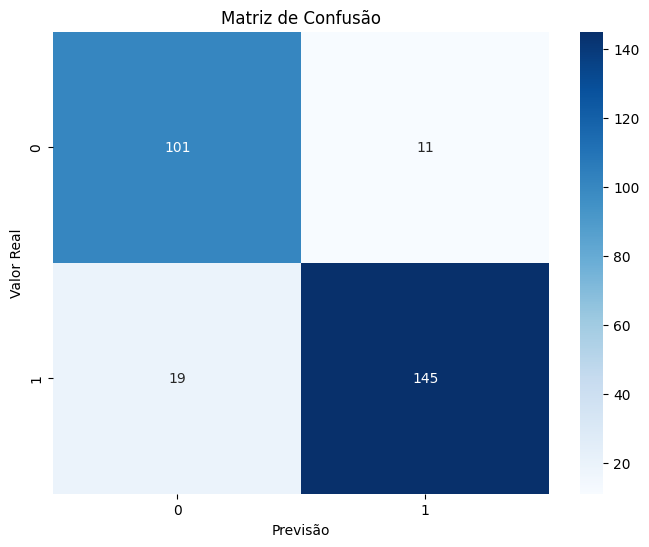

In [16]:
# Sort the list of accuracies in descending order
models_list = sorted(models_list, key=lambda d: d['model_accuracy'])

# Select the model with the highest accuracy
best_model = models_list[-1]
best_model_clf = best_model.get("model_instance")

# Make predictions on the test set
y_pred = best_model_clf.predict(x_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix graph
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Previsão')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão')
plt.show()

In [17]:
print(best_model)

{'model_name': 'Random Forest', 'model_instance': RandomForestClassifier(criterion='entropy', max_depth=7), 'model_accuracy': 0.8913043478260869, 'train_time': datetime.timedelta(seconds=387, microseconds=456915)}


## ROC curve (AUC)
<p>The AUC is a metric that evaluates the ability of a classification model to distinguish correctly between two classes. It is used to compare models, select relevant features, establish classification thresholds, and monitor performance over time. The AUC curve summarizes the overall quality of the model, regardless of the chosen cutoff point, and it is a widely used measure in the analysis of classifier performance.<p>

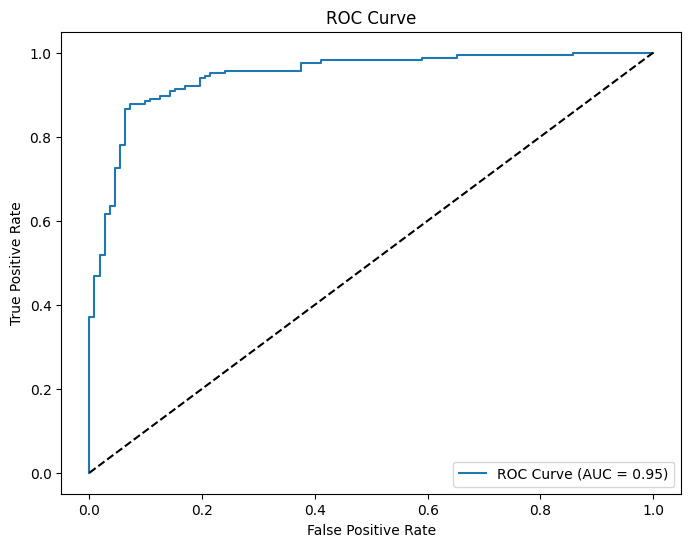

In [18]:
# Make probability predictions on the test set
y_prob = best_model_clf.predict_proba(x_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# ROC curve graph
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()